In [1]:
#| output: false
%matplotlib inline
from input_environment_defs import *
from deficit_defs import Results

Splikes version  0.1.2
Plasticnet version  0.1.9
macOS-10.16-x86_64-i386-64bit



## Synaptic Modification

## The BCM Learning Rule
We use a single neuron and the parabolic form of the BCM[@BCM82;@Blais:2008kx] learning rule for all of the simulations, where the synaptic modification depends on the postsynaptic activity, $y$, in the following way for a single neuron

$$
y=\sigma\left(\sum_i x_i w_i \right)
$$
$$
\frac{dw_i}{dt} = \eta y(y-\theta_M) x_i
$$
$$
\frac{d\theta_M}{dt} = (y^2-\theta_M)/\tau
$$

where is $x_i$ is the $i$th  presynaptic input, $w_i$  is the $i$th synaptic weight, and $y$ is the postsynaptic output activity.  The constant, $\eta$, refers to the learning rate and the constant, $\tau$, is what we call the memory-constant and is related to the speed of the sliding threshold. The transfer function, $\sigma(\cdot)$, places minimum and maximum responses given a set of inputs and weights. 



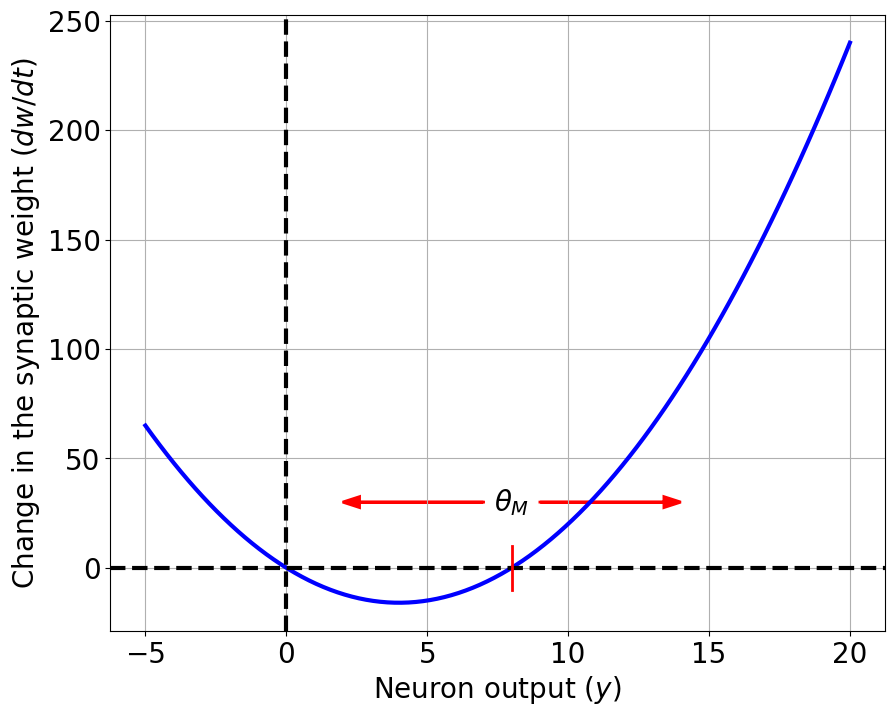

In [2]:
#| label: fig-phi
#| fig-cap: The BCM synaptic modification function.  Units are arbitrary.

y=np.linspace(-5,20,100)
θ_M=8
ϕ=y*(y-θ_M)

plot(y,ϕ,'b-')

yl=gca().get_ylim()
plot([0,0],yl,'k--')
gca().set_ylim(yl)

xl=gca().get_xlim()
plot(xl,[0,0],'k--')
gca().set_xlim(xl)

plt.text(θ_M,30,r'$\theta_M$',ha='center',va='center')
plt.arrow(θ_M+1,30,5,0,color='r',length_includes_head=True,
              head_width=5, head_length=.6,lw=2)
plt.arrow(θ_M-1,30,-5,0,color='r',length_includes_head=True,
              head_width=5, head_length=.6,lw=2)
plot([θ_M,θ_M],[-10,10],'r-',lw=2)
xlabel('Neuron output ($y$)')
ylabel('Change in the synaptic weight ($dw/dt$)');

plt.savefig('Manuscript/resources/fig-bcm-phi.png')
plt.savefig('Manuscript/resources/fig-bcm-phi.svg')        



The results are extremely robust to values of $\eta$  and $\tau$ , which are generally chosen for practical, rather than theoretical, considerations.   Each of these constants is related to the time-step for the simulations, but given the phenomenological nature of the BCM theory it is beyond the scope of this paper to make detailed comparisons between simulation time and real-time.  Further, the fact that $\tau$ can be changed within a factor of 100 with no noticeable effect, the experiments presented here cannot be used address the time-scales of the molecular mechanisms underlying synaptic modification.  Whenever we refer to real-time units for a simulation, we approximate a single simulation iteration as 1 iteration = 0.2 seconds[@phd:Blais98].

In the BCM learning rule, weights decrease if $y$ is less than the modification threshold,$\theta_M$  , and increase if $y$  is greater than the modification threshold.  To stabilize learning, the modification threshold "slides" as a super-linear function of the output.  The output, $y$ , is related to the product of the inputs and the weights via a sigmoidal function, $\sigma(\cdot)$, which places constraints on the values of the output, keeping it in the range -1 and 50.  The interpretation of negative values is consistent with previous work[@BlaisEtAl98], where the activity values are measured relative to spontaneous activity.  Thus, negative values are interpreted as activity below spontaneous.  We continue this usage, in order to more easily compare with previous simulations.  The role of the spontaneous level for the simulations in the natural image environment is discussed elsewhere[@BlaisEtAl98].


## Simulation

The synaptic weights, and the modification threshold, are set to small random initial values at the beginning of a simulation.  At each iteration, an input patch is generated as described above depending on the procedure being simulated and then presented to the neuron.  After each input patch is presented, the weights are modified using the output of the neuron, the input values and the current value of the modification threshold.   In an input environment composed of patches taken from natural images, with equal patches presented to the left- and right-eyes as shown in @fig-normal-inputs, this process orientation selective and fully binocular cells[@BlaisEtAl98].  We then present test stimulus made from sine-gratings with 24 orientations, 20 spatial frequencies, and optimized over phase.  Applying any of the blur filters to the sine gratings does not quantitatively change the result. 


In [4]:
#| output: false
base_image_file='asdf/bbsk081604_all_scale2.asdf'

fname=pi5.filtered_images(
                    base_image_file,
                    {'type':'dog','sd1':1,'sd2':3},
                    {'type':'norm'},
                    )

pre1=pn.neurons.natural_images(fname,
                               rf_size=19,verbose=False)

pre2=pn.neurons.natural_images(fname,rf_size=19,
                            other_channel=pre1,
                            verbose=False)

pre1+=pn.neurons.process.add_noise_normal(0,0.5) # a little noise
pre2+=pn.neurons.process.add_noise_normal(0,0.5) # a little noise


pre=pre1+pre2

number_of_neurons=5
post=pn.neurons.linear_neuron(number_of_neurons)
post+=pn.neurons.process.sigmoid(0,50)

c=pn.connections.BCM(pre,post,[-.01,.01],[.1,.2])
c+=pn.connections.process.orthogonalization(10*minute)
c.eta=2e-6
c.tau=15*minute   

sim=pn.simulation(4*day)
sim.dt=200*ms

save_interval=30*minute
sim.monitor(post,['output'],save_interval)
sim.monitor(c,['weights','theta'],save_interval)

sim+=pn.grating_response()

pn.run_sim(sim,[pre,post],[c],display_hash=True,print_time=True)
pn.save('sims/nr.asdf',sim,[pre,post],[c])
R=Results('sims/nr.asdf')

 [#############################98% (ETA: 0.9 s)############################# ]Grating time elapsed 6.17 s
Sim Time Elapsed...50.24 s


In [5]:
def argmax_rc(X):
    """Return the row and col of the maximum value"""
    r,c=np.unravel_index(np.argmax(X), X.shape)
    return r,c

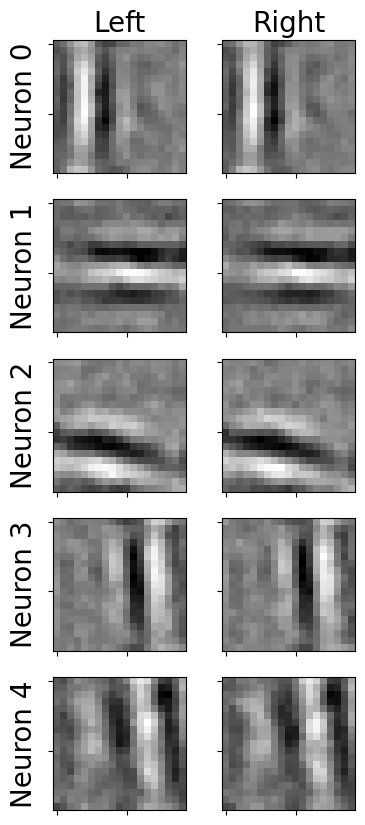

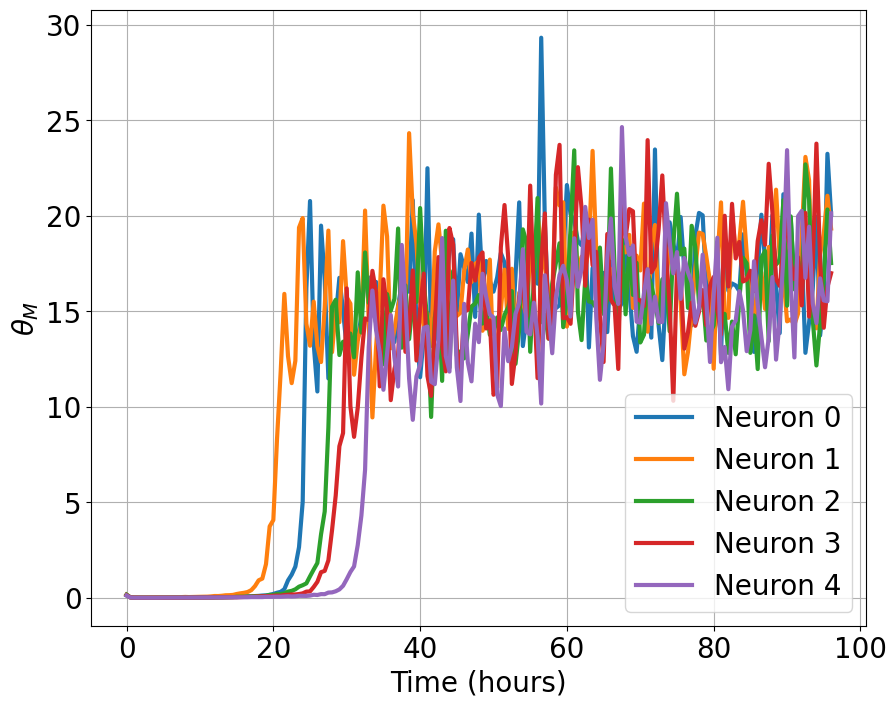

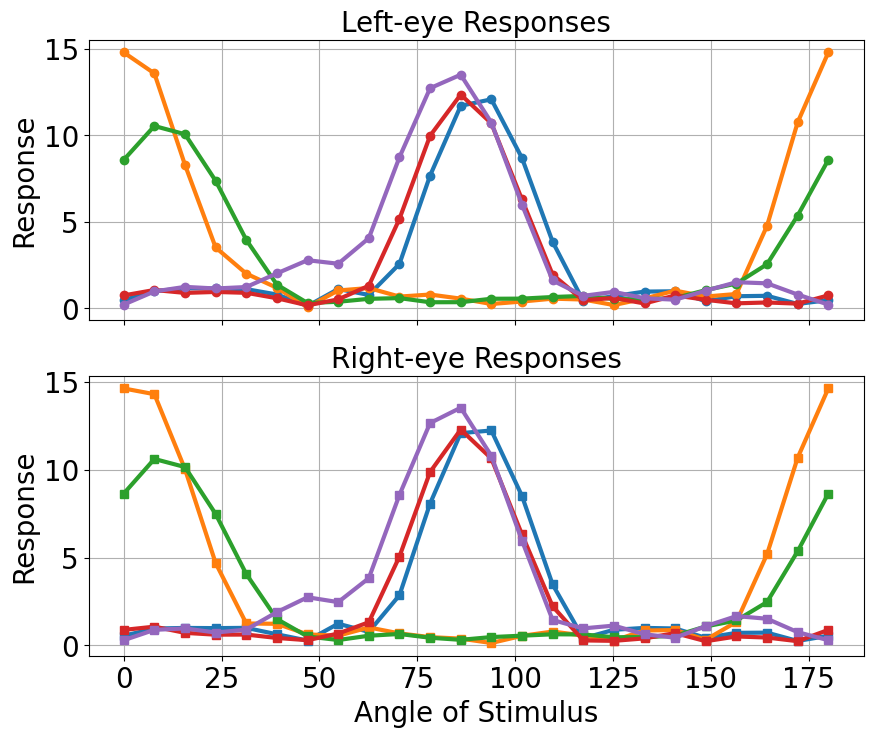

In [6]:
#| label: fig-nr_sim
#| fig-cap: Simulation of 5 neurons receiving identical natural image patterns into the left- and right-input channels.
#| layout: [[1,1], [1]]
#| fig-subcap: 
#|   - "Synaptic weights where black denotes weak weights and white denotes strone weights. A clear preference for oriented stimuli can be seen."
#|   - "BCM modification threshold over time.  The value converges to nearly the same level for all neurons."
#|   - "Responses to Oriented Stimuli after training.  Each neuron develops orientation selectivity to a range of optimum angles."

figure(figsize=(4,10))
R.plot_rf()

figure(figsize=(10,8))
plot(R.t/hour,R.θ,label=[f'Neuron {i}' for i in [0,1,2,3,4]])
ylabel(r'$\theta_M$')
xlabel('Time (hours)')
legend();

figure(figsize=(10,8))
t,y=R.all_responses[0]
for neuron in range(5):
    subplot(2,1,1)
    y_left=y[:,:,0,neuron,-1]  
    y_right=y[:,:,1,neuron,-1]  
    
    r,c=argmax_rc(y_left)
    tuning_curve=y_left[r,:]    
    plot(R.theta_mat,tuning_curve,'-o')
    plt.title('Left-eye Responses')
    ylabel('Response')
    gca().set_xticklabels([])
    
    subplot(2,1,2)
    r,c=argmax_rc(y_right)
    tuning_curve=y_right[r,:]
    plot(R.theta_mat,tuning_curve,'-s')    
    plt.title('Right-eye Responses')
    ylabel('Response')
    xlabel('Angle of Stimulus')
    


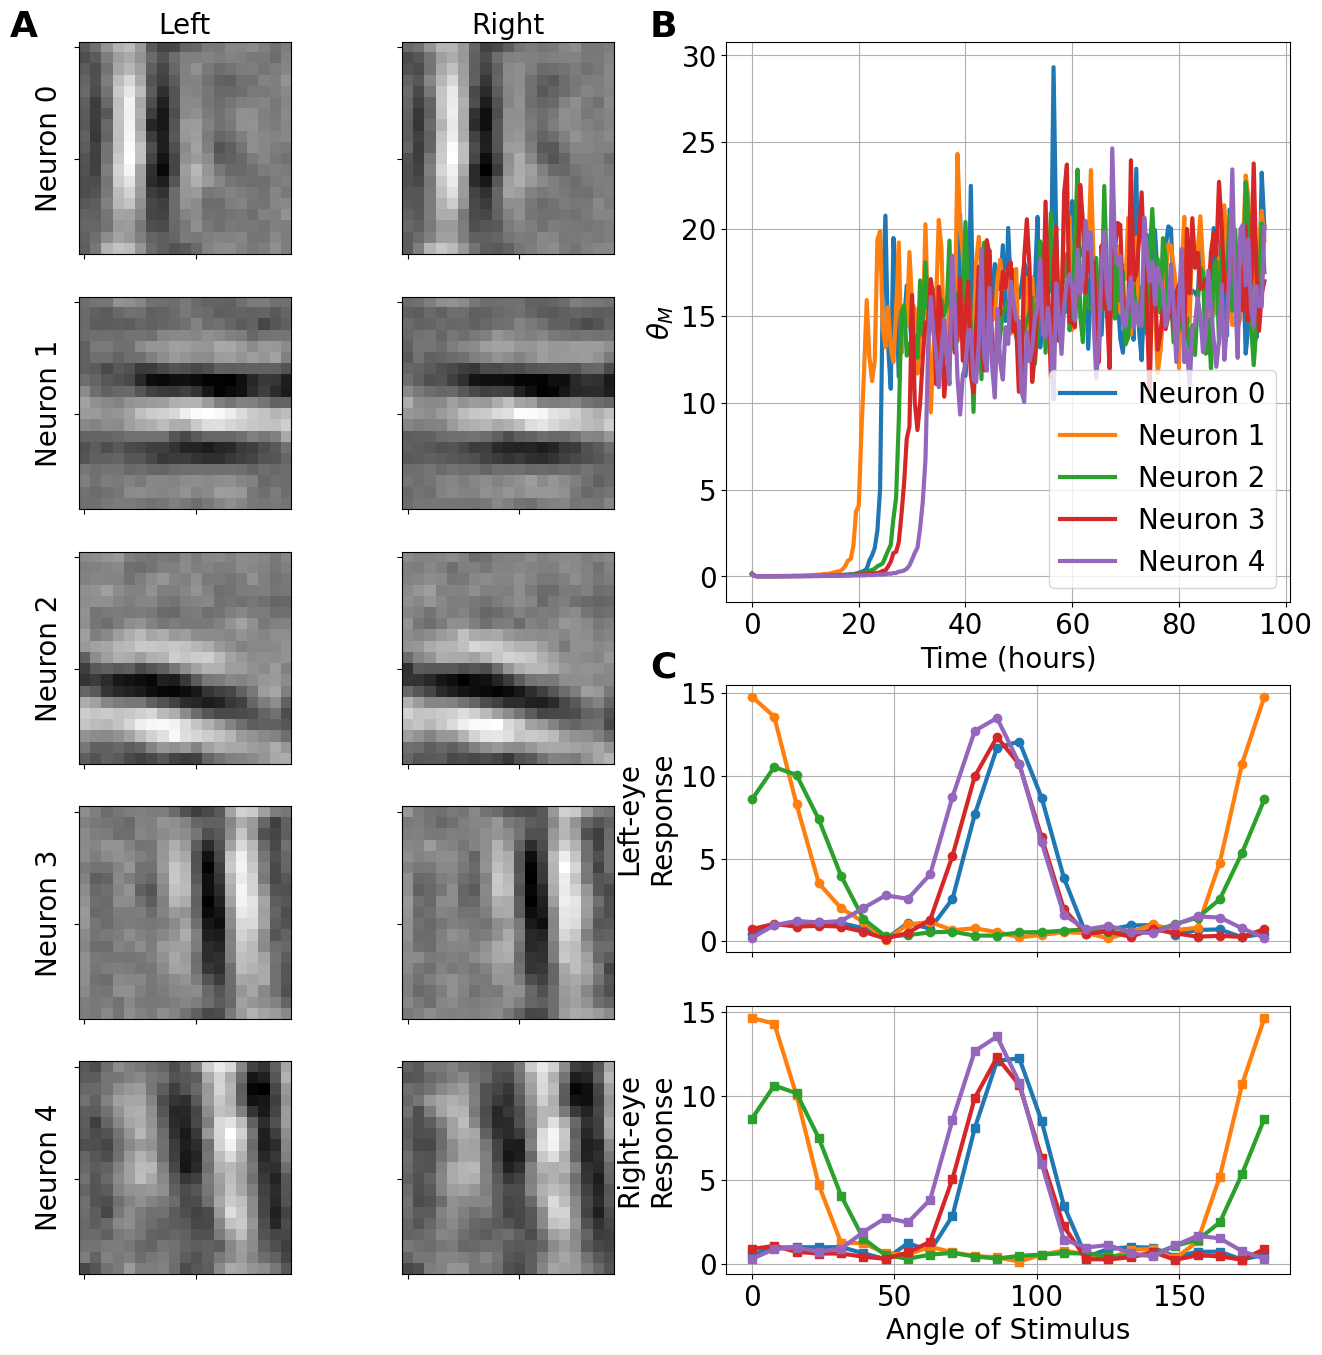

In [7]:
def mysubplot(R,C,r,c):
    from matplotlib.pyplot import subplot2grid
    subplot2grid((R, C), (r, c))

    
figure(figsize=(16,16))
    
w_im=R.weight_image(R.W[-1,::])
number_of_neurons=w_im.shape[0]

for n in range(number_of_neurons):
    vmin=w_im[n,:,:,:].min()
    vmax=w_im[n,:,:,:].max()
    for c in range(2):
        mysubplot(number_of_neurons,4,n,c)
        im=w_im[n,c,:,:]
        imshow(im,cmap=plt.cm.gray,vmin=vmin,vmax=vmax,interpolation='nearest')
        plt.grid(False)
        if c==0:
            ylabel(f'Neuron {n}')
            
        if n==0:
            if c==0:
                title("Left")
            else:
                title("Right")
            
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        
        if n==0 and c==0:  # upper left
            
            plt.text(.1, 0.9, "A", transform=plt.gcf().transFigure,
                fontsize=26, fontweight='bold', va='top')


        
mysubplot(2,2,0,1)
plot(R.t/hour,R.θ,label=[f'Neuron {i}' for i in [0,1,2,3,4]])
ylabel(r'$\theta_M$')
xlabel('Time (hours)')
legend();
plt.text(.5, 0.9, "B", transform=plt.gcf().transFigure,
    fontsize=26, fontweight='bold', va='top')
        
        
t,y=R.all_responses[0]
mysubplot(4,2,2,1)
for neuron in range(number_of_neurons):
    y_left=y[:,:,0,neuron,-1]  
    y_right=y[:,:,1,neuron,-1]  
    
    r,c=argmax_rc(y_left)
    tuning_curve=y_left[r,:]    
    plot(R.theta_mat,tuning_curve,'-o')
    ylabel('Left-eye\nResponse')
    gca().set_xticklabels([])

    
    
mysubplot(4,2,3,1)
for neuron in range(number_of_neurons):
    y_left=y[:,:,0,neuron,-1]  
    y_right=y[:,:,1,neuron,-1]  
    
    r,c=argmax_rc(y_right)
    tuning_curve=y_right[r,:]
    plot(R.theta_mat,tuning_curve,'-s')    
    ylabel('Right-eye\nResponse')
    xlabel('Angle of Stimulus')
        
plt.text(.5, 0.5, "C", transform=plt.gcf().transFigure,
    fontsize=26, fontweight='bold', va='top')
        
    
plt.savefig('Manuscript/resources/fig-rf-theta-tuning-curve.png')
plt.savefig('Manuscript/resources/fig-rf-theta-tuning-curve.svg')        
    